# Определение перспективного тарифа для телеком компании

**Задача:** Провести предварительный анализ тарифов на небольшой выборке клиентов с целью определить по поведению клиентов какой из двух тарифов лучше и приносит больше денег. Результат исследования будет учитываться при корректировке рекламного бюджета. 

**Исходные данные:** Данные 500 пользователей сотового оператора: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

<a id='content'></a>
## Оглавление 
[Предварительный анализ данных](#1)

[Расчет параметров для пользователей](#2)
 - [Расчет для каждого пользователя количества сделанных звонков и израсходованных минут разговора по месяцам](#2-1)
 - [Расчет для каждого пользователя количества отправленных сообщений по месяцам](#2-2)
 - [Расчет для каждого пользователя объема израсходованного интернет-трафика по месяцам](#2-3)
 - [Расчет помесячной прибыли с каждого пользователя](#2-4)
 
[Исследовательский анализ данных](#3)

[Проверка гипотез](#4)
 - [Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#4-1)
 - [Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#4-2)

[Вывод](#outcome)

<a id = '1'></a>
## Предварительный анализ данных

In [1]:
# импорт библиотек
from scipy import stats as st
import numpy as np
import pandas as pd
import math
import copy
import seaborn as sns 

In [2]:
# чтение данных из файлов
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Calls

In [3]:
# проверка данных
calls.info()
calls.duplicated().sum()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Call_date нужно перевести в формат datetime, длительность разговора округлить до минут. Дубликатов и пропущенных значений нет

Для дальнейшего расчета добавлен столбец с месяцем события

In [4]:
# перевод формата столбца call_date в datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

# округление длительности разговора до минут
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value).astype('int')

# столбец с месяцами звонков
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


### Internet

In [5]:
# проверка данных
internet.info()
internet.duplicated().sum()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Session_date нужно перевести в формат datetime. Пропущенных значений и дубликатов нет. Для дальнейших расчетов будет добавлен столбец с месяцем события

In [6]:
# перевод формата столбца session_date в datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

# столбец с месяцами звонков
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

### Messages

In [7]:
# проверка данных
messages.info()
messages.duplicated().sum()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


message_date нужно перевести в формат datetime. Пропущенных значений и дубликатов нет. Для дальнейших расчетов будет добавлен столбец с месяцем события

In [8]:
# перевод формата столбца session_date в datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

# добавление столбца с месяцем отправки сообщения
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

### tariffs

In [9]:
# проверка данных
tariffs.info()
tariffs.duplicated().sum()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные в порядке

 ### users

In [10]:
# проверка данных
users.info()
users.duplicated().sum()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В столбцах churn_date и reg_date данные нужно привести к формату datetime. Для далнейшего расчета тарифы будут закодированы в 0 и 1. В столбце churn_date большинство значений пропущено. Оставим без изменений

In [11]:
#перевод данных в столбцах churn_date и reg_date в формат datetime 
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# добавление индекса тарифного плана
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
users['tariff_id'] = users['tariff'].apply(tariff_id)

<b>Вывод:</b> была выполнена проверка и предобработка данных. Данные в исходных файлах приведены к нужным форматам. Ошибок в данных не обнаружено, много пропущенных значений

[К оглавлению](#content)

<a id = '2'></a>
## Расчет параметров для пользователей

Расчет для каждого пользователя: количества сделанных звонков и израсходованных минут разговора по месяцам, количества отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячная выручка с каждого пользователя.

<a id = '2-1'></a>
### Расчет для каждого пользователя количества сделанных звонков и израсходованных минут разговора по месяцам

In [12]:
# ф-ция cоздания таблицы количества ресурсов по месяцам
def amount_by_month(data_in, values_column, func):
    data_out = data_in.pivot_table(index = 'user_id', values = values_column, columns = 'month', aggfunc = func)
    data_out.reset_index(inplace=True)
    return data_out

# количество сделанных звонков по месяцам
amount_calls_by_month = amount_by_month(calls, 'duration', 'count')
amount_calls_by_month

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
2,1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0
4,1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,112.0,152.0,129.0,155.0
488,1496,7.0,77.0,79.0,67.0,63.0,74.0,73.0,88.0,68.0,72.0,80.0,80.0
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,64.0,71.0
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,23.0,57.0,59.0,41.0,NaN,NaN


In [13]:
# количество израсходованных минут разговора по месяцам
amount_minutes_by_month = amount_by_month(calls, 'duration', 'sum')
amount_minutes_by_month

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
488,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
489,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0
490,1498,NaN,NaN,NaN,NaN,NaN,NaN,175.0,400.0,471.0,247.0,NaN,NaN


[К оглавлению](#content)

<a id = '2-2'></a>
### Расчет для каждого пользователя количества отправленных сообщений по месяцам

In [14]:
# количество отправленных сообщений по месяцам
amount_messages_by_month = amount_by_month(messages, 'id', 'count')
amount_messages_by_month

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
3,1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
422,1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
423,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
424,1498,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


[К оглавлению](#content)

<a id='2-3'></a>
### Расчет для каждого пользователя объема израсходованного интернет-трафика по месяцам

In [15]:
# количество израсходованного траффика по месяцам
amount_mb_by_month = amount_by_month(internet, 'mb_used', 'sum')
amount_mb_by_month

month,user_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
2,1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53
4,1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76
493,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
494,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11500.29,14156.08,19918.60
495,1498,NaN,NaN,NaN,NaN,NaN,NaN,7476.24,24235.21,22134.41,20579.36,NaN,NaN


[К оглавлению](#content)

<a id='2-4'></a>
### Расчет помесячной прибыли с каждого пользователя

In [16]:
# ф-ция добавления идентификатора тарифного плана в таблицу
def add_tariff_id(data_in):
    data_out = data_in.merge(users[['user_id', 'tariff_id']], on='user_id', how='right') 
    return data_out

# ф-ция расчета превышения лимита
def over_limit(row, value_column, limit_column):
    result = row[value_column] - row[limit_column]
    if result > 0:
        return result
    elif result <= 0:
        return 0
    return result
def add_over_limit(data, limit_column):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(over_limit, axis=1, args = [i, limit_column])
    return data

# ф-ция добавления необходимых данных о тарифе в зав-ти от тарифного плана
def tariffs_info(row, info_column):
    result = tariffs[info_column][row['tariff_id']]
    return result
def add_tariffs_info(data, info_column):
    data[info_column] = data.apply(tariffs_info, axis = 1, args = [info_column])
    return data

# ф-ция расчета прибыли за превышение лимита
def profit_user_month(row, value_column, price_column):
    result = row[value_column] * row[price_column]
    return result
def add_profit_user_month(data, price_column):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(profit_user_month, axis=1, args = [i, price_column])
    return data

# расчет стоимости превышения лимита количества минут
# копия amount_minutes_by_month для расчета превышения тарифа
amount_minutes_by_month_profit = copy.deepcopy(amount_minutes_by_month)

# добавление тарифного плана в таблицу и информации о тарифе
amount_minutes_by_month_profit = add_tariff_id(amount_minutes_by_month_profit)

# добавим в таблицу данные о количестве включенных минут и стоимость одной превышенной минуты
add_tariffs_info(amount_minutes_by_month_profit, 'minutes_included')
add_tariffs_info(amount_minutes_by_month_profit, 'rub_per_minute')

# расчет стоимости превышения лимитов
add_over_limit(amount_minutes_by_month_profit, 'minutes_included')
add_profit_user_month(amount_minutes_by_month_profit, 'rub_per_minute')

columns = ['user_id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'tariff_id', 'minutes_included', 'rub_per_minute']
amount_minutes_by_month_profit.columns = columns

amount_minutes_by_month_profit

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,minutes_included,rub_per_minute
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,500,3
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,3000,1
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3000,1
496,1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3000,1
497,1371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,500,3
498,1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3000,1


В таблице много пропущенных значений: в этот месяц пользователь не совершал звонки. 

В таблице много нулевых значений: в этот месяц пользователь не превышал лимит

In [17]:
# расчет стоимости превышения лимита количества сообщений 
amount_messages_by_month_profit = copy.deepcopy(amount_messages_by_month)

# добавление тарифного плана в таблицу и информации о тарифе
amount_messages_by_month_profit = add_tariff_id(amount_messages_by_month_profit)
add_tariffs_info(amount_messages_by_month_profit, 'messages_included')
add_tariffs_info(amount_messages_by_month_profit, 'rub_per_message')

# расчет стоимости превышения лимитов
add_over_limit(amount_messages_by_month_profit, 'messages_included')
add_profit_user_month(amount_messages_by_month_profit, 'rub_per_message')

columns = ['user_id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'tariff_id', 'messages_included', 'rub_per_message']
amount_messages_by_month_profit.columns = columns

amount_messages_by_month_profit

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,messages_included,rub_per_message
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000,1
1,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,50,3
2,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,1000,1
3,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000,1
4,1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,0,50,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,50,3
496,1466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1000,1
497,1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1000,1
498,1479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,50,3


В таблице много пропущенных значений: в этом месяце пользователь не отправлял сообщения. 

В таблице много нулевых значений: в этом месяце пользователь не превышал лимит

In [18]:
# расчет стоимости превышения лимита количества сообщений 
amount_mb_by_month_profit = copy.deepcopy(amount_mb_by_month)

# добавление тарифного плана в таблицу и информации о тарифе
amount_mb_by_month_profit = add_tariff_id(amount_mb_by_month_profit)
add_tariffs_info(amount_mb_by_month_profit, 'mb_per_month_included')
add_tariffs_info(amount_mb_by_month_profit, 'rub_per_gb')

# расчет стоимости превышения лимитов
# расчет превышения в мб
add_over_limit(amount_mb_by_month_profit, 'mb_per_month_included')

# округление мб до гб
def mb_used_value(row):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        row[i] = math.ceil(row[i] / 1024)
    return row

# округление мб до гб
amount_mb_by_month_profit = amount_mb_by_month_profit.fillna(0)
amount_mb_by_month_profit = amount_mb_by_month_profit.apply(mb_used_value, axis=1) 
# расчет стоимости в гб
add_profit_user_month(amount_mb_by_month_profit, 'rub_per_gb')

columns = ['user_id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'tariff_id', 'mb_per_month_included', 'rub_per_gb']
amount_mb_by_month_profit.columns = columns

amount_mb_by_month_profit

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mb_per_month_included,rub_per_gb
0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30720.0,150.0
1,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,15360.0,200.0
2,1002.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,0.0,15360.0,200.0
3,1003.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30720.0,150.0
4,1004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30720.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1498.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,1400.0,1200.0,0.0,0.0,0.0,15360.0,200.0
496,1499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,600.0,0.0,0.0,15360.0,200.0
497,1128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30720.0,150.0
498,1273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30720.0,150.0


В таблице много пропущенных значений: в этом месяце пользователь не пользовался интернетом.

В таблице много нулевых значений: в этом месяце пользователь не превышал лимит

In [19]:
# Расчет суммарной прибыли с каждого пользователя по месяцам

# расчет стоимости превышения за месяц
def profit_by_user_by_month(table1, table2, column):
    result = table1.merge(table2, on=column, suffixes=('_1', '_2'))
    for i in range(1, 13):
        result[str(i)] = result[str(i) + '_1'] + result[str(i) + '_2']
    return result.loc[:, ['user_id', '1','2', '3', '4', '5', '6', '7', '8', '9', '10','11', '12', 'tariff_id_1']]

#сложим таблицы превышений по минутам, сообщениям и интернет
profit_by_user = profit_by_user_by_month(amount_mb_by_month_profit, amount_messages_by_month_profit, 'user_id')
profit_by_user = profit_by_user_by_month(profit_by_user, amount_mb_by_month_profit, 'user_id')

# прибавим тарифный план
profit_by_user = profit_by_user.rename(columns={'tariff_id_1': 'tariff_id'})
add_tariffs_info(profit_by_user, 'rub_monthly_fee')
for i in range(1, 13):
    profit_by_user[str(i)] = profit_by_user[str(i)] + profit_by_user['rub_monthly_fee']
    
profit_by_user

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,rub_monthly_fee
0,1000.0,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1.0,1950
1,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,550
2,1002.0,NaN,NaN,NaN,NaN,NaN,550.0,1750.0,2550.0,1350.0,550.0,2150.0,1750.0,0.0,550
3,1003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1.0,1950
4,1004.0,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1.0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1498.0,NaN,NaN,NaN,NaN,NaN,NaN,550.0,4186.0,3350.0,2950.0,NaN,NaN,0.0,550
496,1499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,1750.0,1777.0,598.0,0.0,550
497,1128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1950
498,1273.0,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1.0,1950


Были расчитаны количество использованных минут, сообщений и интернет траффика в месяц по каждому пользователю.

Так же было расчитана прибыль по каждому клиенту в месяц с учетом тарифного плана и превышений по использованным ресурсам

[К оглавлению](#content)

<a id='3'></a>
## Исследовательский анализ данных

Необходимо определить, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [20]:
# расчет среднего
def mean_value(row):
    return row[1:12].mean()

# расчет дисперсии
def variation_value(row):
    result = row[1:12].var()
    return result

# расчет СКО
def std_value(row):
    result = row[1:12].std()
    return result

# расчет среднего, дисперсии и СКО для ресурсов 
amount_minutes_by_month['minutes_mean_values'] = amount_minutes_by_month.apply(mean_value, axis=1)
amount_minutes_by_month['minutes_variation_values'] = amount_minutes_by_month.apply(variation_value, axis=1)
amount_minutes_by_month['minutes_std_values'] = amount_minutes_by_month.apply(std_value, axis=1)
amount_messages_by_month['messages_mean_values'] = amount_messages_by_month.apply(mean_value, axis=1)
amount_messages_by_month['messages_variation_values'] = amount_messages_by_month.apply(variation_value, axis=1)
amount_messages_by_month['messages_std_values'] = amount_messages_by_month.apply(std_value, axis=1)
amount_mb_by_month['mb_mean_values'] = amount_mb_by_month.apply(mean_value, axis=1)
amount_mb_by_month['mb_variation_values'] = amount_mb_by_month.apply(variation_value, axis=1)
amount_mb_by_month['mb_std_values'] = amount_mb_by_month.apply(std_value, axis=1)

# расчет среднего, дисперсии и СКО для прибыли
profit_by_user['profit_mean_values'] = profit_by_user.apply(mean_value, axis=1)
profit_by_user['profit_variation_values'] = profit_by_user.apply(variation_value, axis=1)
profit_by_user['profit_std_values'] = profit_by_user.apply(std_value, axis=1)

# обединим все значения в одну таблицу
# ф-ция объединения таблиц по 'user_id'
def merge_tables(table1, table2):
    result = table1.merge(table2, on='user_id')
    return result

stat_values = users[['user_id', 'tariff_id']]
stat_values = merge_tables(stat_values, amount_minutes_by_month[['user_id', 'minutes_mean_values', 'minutes_variation_values', 'minutes_std_values']])
stat_values = merge_tables(stat_values, amount_messages_by_month[['user_id', 'messages_mean_values', 'messages_variation_values', 'messages_std_values']])
stat_values = merge_tables(stat_values, amount_mb_by_month[['user_id', 'mb_mean_values', 'mb_variation_values', 'mb_std_values']])
stat_values = merge_tables(stat_values, profit_by_user[['user_id', 'profit_mean_values', 'profit_variation_values', 'profit_std_values']])

stat_values

,user_id,tariff_id,minutes_mean_values,minutes_variation_values,minutes_std_values,messages_mean_values,messages_variation_values,messages_std_values,mb_mean_values,mb_variation_values,mb_std_values,profit_mean_values,profit_variation_values,profit_std_values
0,1000,1,319.000000,13083.666667,114.383857,60.857143,381.142857,19.522880,13939.242857,3.743495e+07,6118.410805,1950.000000,0.000000e+00,0.000000
1,1002,0,213.500000,3188.300000,56.465033,9.666667,23.466667,4.844241,16320.465000,1.172399e+07,3424.030783,1483.333333,6.826667e+05,826.236447
2,1003,1,755.000000,65940.666667,256.789148,76.250000,706.250000,26.575365,11789.777500,6.639012e+06,2576.628091,1950.000000,0.000000e+00,0.000000
3,1004,1,122.428571,1823.619048,42.703853,147.142857,748.476190,27.358293,18716.920000,2.697849e+07,5194.081736,1950.000000,0.000000e+00,0.000000
4,1005,0,546.636364,29108.654545,170.612586,45.272727,221.018182,14.866680,8274.465455,6.538724e+06,2557.092917,557.909091,1.768909e+02,13.300034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1495,1,722.250000,184622.916667,429.677689,64.000000,1158.000000,34.029399,25995.950000,2.585277e+08,16078.798104,2850.000000,1.620000e+06,1272.792206
415,1496,0,496.909091,25639.890909,160.124611,37.909091,126.690909,11.255706,22746.012727,4.645078e+07,6815.480708,4004.545455,2.376727e+06,1541.663800
416,1497,0,430.500000,7080.500000,84.145707,17.000000,18.000000,4.242641,12828.185000,3.526610e+06,1877.927118,550.000000,0.000000e+00,0.000000
417,1498,0,323.250000,18504.250000,136.030328,42.000000,296.000000,17.204651,18606.305000,5.730113e+07,7569.750972,2759.000000,2.433924e+06,1560.103843


In [21]:
# создадим две таблицы по тарифам
smart = stat_values[stat_values['tariff_id'] == 0]
ultra = stat_values[stat_values['tariff_id'] == 1]

In [22]:
# Описание тарифа SMART
print('Тариф SMART, средние значения за месяц:')
print('')
print('Минут разговора:', smart['minutes_mean_values'].describe()['mean'])
print('Сообщений:', smart['messages_mean_values'].describe()['mean'])
print('Мегабайт интернета:', smart['mb_mean_values'].describe()['mean'])
print('')
print('Стандартное отклонение минут разговора:', smart['minutes_mean_values'].describe()['std'])
print('Стандартное отклонение сообщений:', smart['messages_mean_values'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', smart['mb_mean_values'].describe()['std'])
print('')
print('Дисперсия минут разговора:', smart['minutes_mean_values'].describe()['std'] ** 2)
print('Дисперсия сообщений:', smart['messages_mean_values'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', smart['mb_mean_values'].describe()['std'] ** 2)
print('')
print('Средний доход с каждого пользователя:', smart['profit_mean_values'].describe()['mean'])

print('')
print('')
print('')

print('Тариф ULTRA, средние значения за месяц:')
print('')
print('Минут разговора:', ultra['minutes_mean_values'].describe()['mean'])
print('Сообщений:', ultra['messages_mean_values'].describe()['mean'])
print('Мегабайт интернета:', ultra['mb_mean_values'].describe()['mean'])
print('')
print('Стандартное отклонение минут разговора:', ultra['minutes_mean_values'].describe()['std'])
print('Стандартное отклонение сообщений:', ultra['messages_mean_values'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', ultra['mb_mean_values'].describe()['std'])
print('')
print('Дисперсия минут разговора:', ultra['minutes_mean_values'].describe()['std'] ** 2)
print('Дисперсия сообщений:', ultra['messages_mean_values'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', ultra['mb_mean_values'].describe()['std'] ** 2)
print('')
print('Средний доход с каждого пользователя:', ultra['profit_mean_values'].describe()['mean'])

Тариф SMART, средние значения за месяц:

Минут разговора: 395.4337321052249
Сообщений: 36.27444240542067
Мегабайт интернета: 15321.45665746234

Стандартное отклонение минут разговора: 143.4453195229042
Стандартное отклонение сообщений: 24.221590783728985
Стандартное отклонение мегабайт интернета: 3998.7263097289847

Дисперсия минут разговора: 20576.559693028084
Дисперсия сообщений: 586.6854600944249
Дисперсия мегабайт интернета: 15989812.100118784

Средний доход с каждого пользователя: 1661.2082617060878



Тариф ULTRA, средние значения за месяц:

Минут разговора: 512.179843073593
Сообщений: 61.86130275974027
Мегабайт интернета: 18266.885484429757

Стандартное отклонение минут разговора: 266.48757085484783
Стандартное отклонение сообщений: 41.78409389129593
Стандартное отклонение мегабайт интернета: 8119.392939671915

Дисперсия минут разговора: 71015.62542011755
Дисперсия сообщений: 1745.910502316634
Дисперсия мегабайт интернета: 65924541.70879414

Средний доход с каждого пользователя:

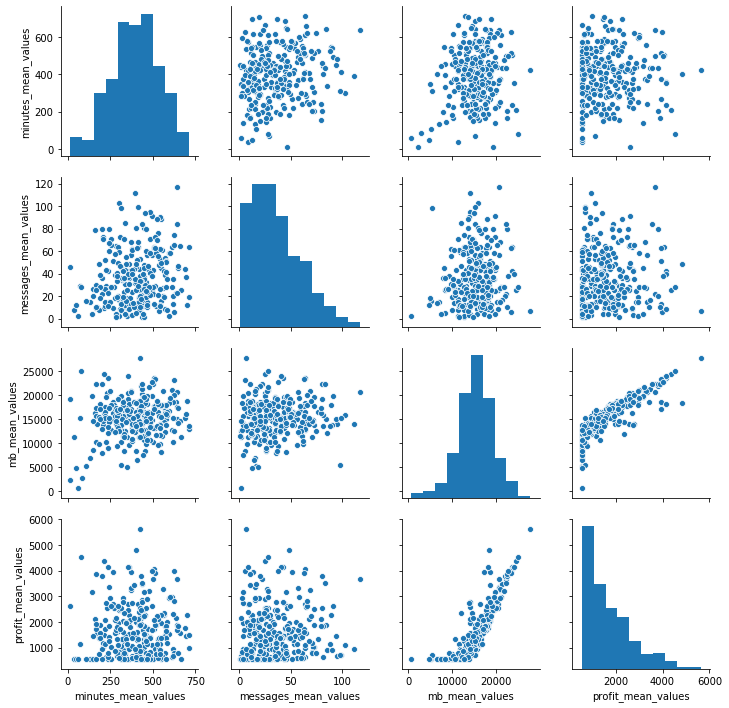

In [23]:
# гистограммы для тарифа SMART
sns.pairplot(smart[['minutes_mean_values', 'messages_mean_values', 'mb_mean_values', 'profit_mean_values']])

Виды распределения для тарифа SMART:

    1. количество минут - нормальное распеделение
    
    2. количество сообщений - распределение Пуассона
    
    3. интернет траффик - распределение нормальное

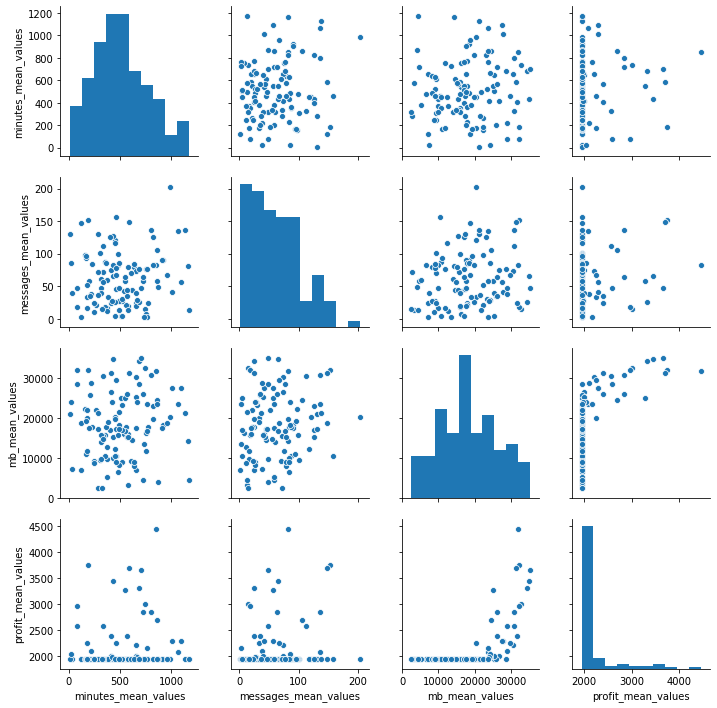

In [24]:
# гистограммы для тарифа ULTRA
sns.pairplot(ultra[['minutes_mean_values', 'messages_mean_values', 'mb_mean_values', 'profit_mean_values']])

Виды распределения для тарифа ULTRA:

    1. количество минут - нормальное распеделение
    
    2. количество сообщений - распределение Пуассона
    
    3. интернет траффик - нормальное распределение

[К оглавлению](#content)

<a id='4'></a>
## Проверка гипотез

Гипотезы для проверки: 
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<a id='4-1'></a>
### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

H0: средняя выручка пользователей тарифов не различается

H1: средняя выручка пользователей тарифов различается

Для проверки гипотезы будет спользован t-тест Стьюдента, т к выборки независимые. Уровень стистической значимости 5%

In [25]:
# проверка гипотезы равенства выручки пользователей тарифов «Ультра» и «Смарт»
results = st.ttest_ind(smart['profit_mean_values'], ultra['profit_mean_values'], equal_var = False, nan_policy='omit')
print('p-значение: ', results.pvalue)

p-значение:  5.292449932263244e-10


Принимаем альтернативную гипотезу: существует статистически значимая разница между средними выручками в тарифах Smart и Ultra

[К оглавлению](#content)

<a id='4-2'></a>
### Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверим эту гипотезу для каждого тарифа отдельно. Нулевая и альтернативные гипотезы для тарфов будут одинаковыми:

H0: Средняя выручка пользователей Москвы не отличается от выручки пользователей из других регионов

H1: Средняя выручка пользователей Москвы отличается от выручки пользователей из регионов

Для проверки гипотез будет спользован t-тест Стьюдента, т к выборки независимые. Уровень значимости примем 5%

In [26]:
# проверим гипотезу для тарифа SMART

# добавим в таблицу информацию о регионе
smart = smart.merge(users[['user_id', 'city']], on='user_id', how='right')

In [27]:
# расчитаем p-value
results = st.ttest_ind(smart[smart['city'] == 'Москва']['profit_mean_values'], smart[smart['city'] != 'Москва']['profit_mean_values'], equal_var = False, nan_policy='omit')
print('p-значение: ', results.pvalue)

p-значение:  0.16729478891107172


Принимаем нулевую гипотезу: для тарифа SMART выручка пользователей Москвы не отличается от выручки пользователей из других регионов

In [28]:
# проверим гипотезу для тарифа ULTRA

# добавим в таблицу информацию о регионе
ultra = ultra.merge(users[['user_id', 'city']], on='user_id')

# расчитаем p-value
results = st.ttest_ind(ultra[ultra['city'] == 'Москва']['profit_mean_values'], ultra[ultra['city'] != 'Москва']['profit_mean_values'], equal_var = False, nan_policy='omit')
print('p-значение: ', results.pvalue)

p-значение:  0.45196203606347873


Принимаем нулевую гипотезу: для тарифа ULTRA выручка пользователей Москвы не отличается от выручки пользователей из других регионов

[К оглавлению](#content)

<a id='outcome'></a>
## Вывод

Были расчитаны средние значения израсходованных минут, сообщений, инернет траффика и прибыли по каждому из тарифов.

Между собой было проведено сравнение прибыли по каждому из тарифов. Прибыли отличаются и <b>тариф ULTRA приносит компании больше денег</b>. При этом не было обнаружено различий в прибыли между Москвой и регионами по обоим тарифам.

[К оглавлению](#content)